# Gradient Boosting Machines -  GBM

- [GBM](https://rpubs.com/omicsdata/gbm)

## Carregando Biblioteca

In [2]:
library(repr)
library(caTools)
options(repr.plot.width = 8, repr.plot.height = 8)
#Boost
library(gbm)
#Preprocessamento
library(CatEncoders)
library(gplots)
#Matricas
library(caret)

## Carregando os dados

In [3]:
df <- read.csv("../datasets/titanic/train.csv", na.strings = '')
head(df)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NA,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NA,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NA,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,NA,Q


## Pré-Processamento de Dados

In [4]:
# Extração de Pronomes
df$Name <- ifelse(grepl(", Mr. ", df$Name), 'Mr', as.character(df$Name))
df$Name <- ifelse(grepl("Capt", df$Name), 'Tripulacao', as.character(df$Name))
df$Name <- ifelse(grepl("Don", df$Name), 'Mr', as.character(df$Name))
df$Name <- ifelse(grepl("Major", df$Name), 'Tripulacao', as.character(df$Name))
df$Name <- ifelse(grepl("Col", df$Name), 'Tripulacao', as.character(df$Name))
df$Name <- ifelse(grepl("Dr", df$Name), 'Dr', as.character(df$Name))
df$Name <- ifelse(grepl("Rev", df$Name), 'Rev', as.character(df$Name))
df$Name <- ifelse(grepl("Sir", df$Name), 'Mr', as.character(df$Name))
df$Name <- ifelse(grepl("Jonkheer", df$Name), 'Mr', as.character(df$Name))
df$Name <- ifelse(grepl("Dona", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Countess", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Mme", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Lady", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Mrs", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Mlle", df$Name), 'Miss', as.character(df$Name))
df$Name <- ifelse(grepl("Ms", df$Name), 'Miss', as.character(df$Name))
df$Name <- ifelse(grepl("Miss", df$Name), 'Miss', as.character(df$Name))
df$Name <- ifelse(grepl("Master", df$Name), 'Master', as.character(df$Name))

# Categóricas para Numéricas
le_name <- LabelEncoder.fit(unique(df$Name))
df$Name <- transform(le_name, df$Name)

# Substituir valores ausentes/nulos
media <- mean(df$Age, na.rm = TRUE)
df$Age <- ifelse(is.na(df$Age), media, df$Age)

t <- table(df$Embarked)
moda <- names(t[t == max(t)])

df$Embarked <- ifelse(is.na(df$Embarked), as.character(moda), as.character(df$Embarked) )

# Categórico Para numérico
le_sex <- LabelEncoder.fit(unique(df$Sex))
df$Sex <- transform(le_sex, df$Sex)

le_embarked <- LabelEncoder.fit(unique(df$Embarked))
df$Embarked <- transform(le_embarked, df$Embarked)

# Remoção de colunas
df$PassengerId <- NULL
df$Ticket <- NULL
df$Cabin <- NULL

#Escalonamento 
df[, c('Age', 'Fare')] <- scale(df[, c('Age', 'Fare')])

df$Name = factor(df$Name)
df$Pclass = factor(df$Pclass)
df$Sex = factor(df$Sex)
df$Embarked = factor(df$Embarked)

head(df)
str(df)

Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,4,2,-0.5921480,1,0,-0.5021631,3
1,1,5,1,0.6384304,1,0,0.7864036,1
1,3,3,1,-0.2845034,0,0,-0.4885799,3
1,1,5,1,0.4076970,1,0,0.4204941,3
0,3,4,2,0.4076970,0,0,-0.4860644,3
0,3,4,2,0.0000000,0,0,-0.4778481,2


'data.frame':	891 obs. of  9 variables:
 $ Survived: int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass  : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name    : Factor w/ 7 levels "1","2","3","4",..: 4 5 3 5 4 4 4 2 5 5 ...
 $ Sex     : Factor w/ 2 levels "1","2": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age     : num  -0.592 0.638 -0.285 0.408 0.408 ...
 $ SibSp   : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch   : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Fare    : num  -0.502 0.786 -0.489 0.42 -0.486 ...
 $ Embarked: Factor w/ 3 levels "1","2","3": 3 1 3 3 3 2 3 3 3 1 ...


# Divisão dos dados em treino e teste

In [5]:
set.seed(0)
divisao <- sample.split(df$Survived, SplitRatio = 0.75)

treino <- subset(df, divisao == TRUE)
teste <-  subset(df, divisao == FALSE)

x_train <- treino[,-1]
y_train <- treino$Survived

x_test <- teste[,-1]
y_test <- teste$Survived

## GBM

Argumentos

- **formula** - Uma descrição simbólica do modelo a ser ajustado. 
- **distribution** - Uma sequência de caracteres especificando o nome da distribuição a ser usada ou uma lista com um nome de componente especificando a distribuição e quaisquer parâmetros adicionais necessários. Se não for especificado, gbm tentará adivinhar gaussian" (squared error), "laplace" (absolute loss), "tdist" (t-distribution loss), "bernoulli" (logistic regression for 0-1 outcomes), "huberized" (huberized hinge loss for 0-1 outcomes), classes), "adaboost" (the AdaBoost exponential loss for 0-1 outcomes), "poisson" (count outcomes), "coxph" (right censored observations), "quantile", or "pairwise" (ranking measure using the LambdaMart algorithm).
- **data** - Um quadro de dados opcional contendo as variáveis no modelo.
- **weights** - Um vetor opcional de pesos a ser usado no processo de adaptação. Deve ser positivo, mas não precisa ser normalizado. 
- **var.monotone** - Um vetor opcional, do mesmo comprimento que o número de preditores, indicando quais variáveis têm uma relação monótona crescente (+1), decrescente (-1) ou arbitrária (0) com o resultado
- **n.trees** - Inteiro especificando o número total de árvores a serem ajustadas. Isso é equivalente ao número de iterações e ao número de funções básicas na expansão aditiva. O padrão é 100. 
- **interaction.depth** - Número inteiro que especifica a profundidade máxima de cada árvore (ou seja, o nível mais alto de interações variáveis permitidas). Um valor de 1 implica um modelo aditivo, um valor de 2 implica um modelo com até interações bidirecionais, etc. O padrão é 1. 
- **n.minobsinnode** - Inteiro especificando o número mínimo de observações nos nós terminais das árvores. Observe que este é o número real de observações, não o peso total. 
- **shrinkage** - Refere-se à taxa de aprendizagem. Um parâmetro de redução aplicado a cada árvore na expansão. Também conhecido como taxa de aprendizagem ou redução do tamanho do passo; 0,001 a 0,1 geralmente funcionam, mas uma taxa de aprendizado menor normalmente requer mais árvores. O padrão é 0,1. 
- **bag.fraction** - A fração das observações do conjunto de treinamento selecionadas aleatoriamente para propor a próxima árvore na expansão. Isso introduz aleatoriedade no ajuste do modelo. Se bag.fraction <1, executar o mesmo modelo duas vezes resultará em ajustes semelhantes, mas diferentes. gbm usa o gerador de números aleatórios R para que set.seed possa garantir que o modelo possa ser reconstruído. De preferência, o usuário pode salvar o gbm.object retornado usando save. O padrão é 0,5. 
- **train.fraction** - As primeiras observações train.fraction * nrows (dados) são usadas para ajustar o gbm e o restante é usado para calcular estimativas fora da amostra da função de perda. 
- **cv.folds** - Número de dobras de validação cruzada a serem executadas. Se cv.folds> 1 então gbm, além do ajuste usual, irá realizar uma validação cruzada, calcular uma estimativa de erro de generalização retornado em cv.error. 
- **keep.data** - Uma variável lógica que indica se os dados devem ser mantidos e um índice dos dados armazenados com o objeto. Manter os dados e o índice torna as chamadas subsequentes para gbm.more mais rápidas ao custo de armazenar uma cópia extra do conjunto de dados. 
- **verbose** - Lógico que indica se deve ou não imprimir indicadores de progresso e desempenho (TRUE). Se esta opção não for especificada para gbm.more, ele usará verbose from object. O padrão é FALSE
- **class.stratify.cv** - Lógica que indica se a validação cruzada deve ou não ser estratificada por classe. O padrão é TRUE para distribuição = "multinomial" e só é implementado para "multinomial" e "bernoulli". O objetivo de estratificar a validação cruzada é ajudar a evitar situações em que os conjuntos de treinamento não contêm todas as classes. 
- **n.cores** - O número de núcleos de CPU a serem usados. O loop de validação cruzada tentará enviar dobras CV diferentes para núcleos diferentes. Se n.cores não for especificado pelo usuário, ele é adivinhado usando a função detectCores no pacote paralelo. Observe que a documentação para detectCores deixa claro que não é à prova de falhas e pode retornar um número espúrio de núcleos disponíveis. 

In [6]:
set.seed(0)
x <- cbind(x_train, y_train)
classificador <- gbm(y_train ~ ., data = x, shrinkage=0.01, distribution = 'bernoulli', cv.folds=5, n.trees=500)

## Exibir o Gráfico de Decisção

- **plot**
- **text**
- **rpart.plot**
- **summary**

In [7]:
classificador

gbm(formula = y_train ~ ., distribution = "bernoulli", data = x, 
    n.trees = 500, shrinkage = 0.01, cv.folds = 5)
A gradient boosted model with bernoulli loss function.
500 iterations were performed.
The best cross-validation iteration was 500.
There were 8 predictors of which 8 had non-zero influence.

,var,rel.inf
Name,Name,56.6330772
Pclass,Pclass,15.7210758
Sex,Sex,14.7164823
SibSp,SibSp,6.7998893
Fare,Fare,3.6253972
Age,Age,1.5508533
Embarked,Embarked,0.8282071
Parch,Parch,0.1250178


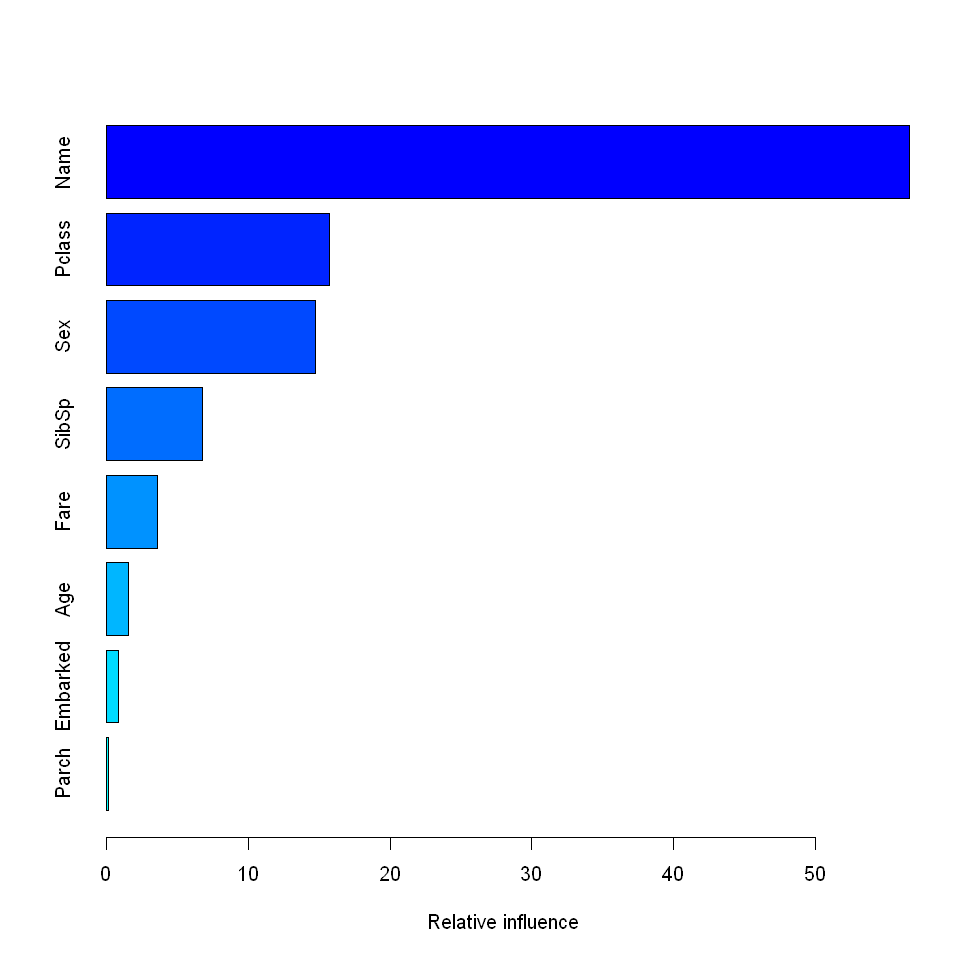

In [8]:
summary(classificador)

## Prever os dados de Teste

- Irá retornar uma matrix contendo a probabilidade de pertencer a cada uma das classes

In [9]:
pred = predict.gbm(object = classificador,
                   newdata = x_test,
                   n.trees = 200,
                   type = "response")

previsao = ifelse((pred > 0.5), 1, 0)

acuracia = 100 * sum(previsao == y_test)/length(y_test)
acuracia

[1] 74.88789

# Matriz de Confusão

- A função **table** realiza o agrupamento dos dados
- A função **confusionMatriz** da biblioteca **caret** também calcula a matriz de confusão + as métricas

In [10]:
matriz_confusao = table(y_test, previsao)
matriz_confusao

      previsao
y_test   0   1
     0 108  29
     1  27  59

In [11]:
matriz = confusionMatrix(factor(previsao), factor(y_test))
matriz

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 108  27
         1  29  59
                                          
               Accuracy : 0.7489          
                 95% CI : (0.6866, 0.8044)
    No Information Rate : 0.6143          
    P-Value [Acc > NIR] : 1.507e-05       
                                          
                  Kappa : 0.4723          
                                          
 Mcnemar's Test P-Value : 0.8937          
                                          
            Sensitivity : 0.7883          
            Specificity : 0.6860          
         Pos Pred Value : 0.8000          
         Neg Pred Value : 0.6705          
             Prevalence : 0.6143          
         Detection Rate : 0.4843          
   Detection Prevalence : 0.6054          
      Balanced Accuracy : 0.7372          
                                          
       'Positive' Class : 0               
                              

## Personalizando a Matriz de Confusão

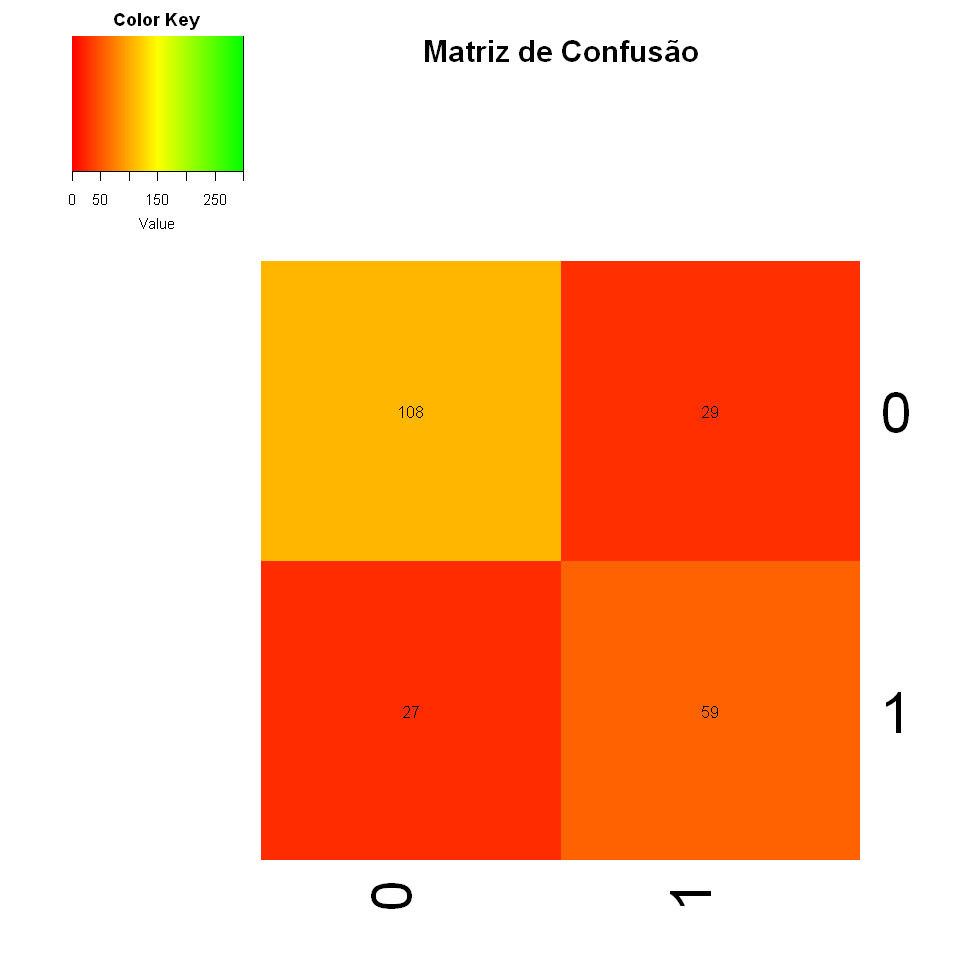

In [12]:
my_palette <- colorRampPalette(c("red", "yellow", "green"))

col_breaks = c(0:50, 51:100, 101:300)

heatmap.2(matriz_confusao,
    Rowv = 'NA',
    cellnote = matriz_confusao, 
    main = "Matriz de Confusão",
    notecol="black",      
    density.info="none",  
    trace="none",        
    col=my_palette,       
    breaks=col_breaks,   
    dendrogram= 'none',     
    Colv="NA" 
)

# Métricas

- **Precisão** que é a fração de instâncias recuperadas que são relevantes, 
- **Recall** - que é a fração de instâncias relevantes que são recuperadas 
- **f-score** - é 2 * precisão * recall / (precisão + recall) é 

In [13]:
precision(factor(previsao), factor(y_test))
'Morto'
precision(factor(previsao), factor(y_test), relevant = 2)
'Vivo'
precision(factor(previsao), factor(y_test), relevant = 1)

[1] 0.8

[1] "Morto"

[1] 0.6704545

[1] "Vivo"

[1] 0.8

In [14]:
recall(factor(previsao), factor(y_test))
'Morto'
recall(factor(previsao), factor(y_test), relevant = 2)
'Vivo'
recall(factor(previsao), factor(y_test), relevant = 1)

[1] 0.7883212

[1] "Morto"

[1] 0.6860465

[1] "Vivo"

[1] 0.7883212

In [15]:
F_meas(factor(previsao), factor(y_test))
'Morto'
F_meas(factor(previsao), factor(y_test), relevant = 2)
'Vivo'
F_meas(factor(previsao), factor(y_test), relevant = 1)

[1] 0.7941176

[1] "Morto"

[1] 0.6781609

[1] "Vivo"

[1] 0.7941176

# Ajustar Parâmetros

In [16]:
set.seed(0)
classificador <- gbm(
    y_train ~ .,
    data = x, 
    distribution = "bernoulli",
    n.trees = 100,
    interaction.depth = 1,
    n.minobsinnode = 10,
    shrinkage = 0.05,
    bag.fraction = 0.5,
    train.fraction = 1,
    cv.folds = 5,
    keep.data = TRUE,
    verbose = FALSE,
)

pred = predict(classificador, newdata = x_test)
previsao <- ifelse((pred[] > 0.5), 1, 0)

'acuracia'
acuracia = 100 * sum(previsao == y_test)/length(y_test)
acuracia

Using 100 trees...



[1] "acuracia"

[1] 78.92377

# Validação Cruzada

- **method = cv** - indica que iremos usar o método crossvalidation
- **number = 10** - define o número de fold
- **method = gbm** - indica que iremos usar o algorítmo de de Boost

In [19]:
controle_treinamento = trainControl(method = 'cv', number = 10)
df$Survived = factor(df$Survived)
modelo = train(Survived ~ ., data = df, trControl = controle_treinamento, method = 'gbm', verbose = FALSE )
modelo$results

,shrinkage,interaction.depth,n.minobsinnode,n.trees,Accuracy,Kappa,AccuracySD,KappaSD
1,0.1,1,10,50,0.8025060,0.5777488,0.04457723,0.09548662
4,0.1,2,10,50,0.8216451,0.6155233,0.03407233,0.07371970
7,0.1,3,10,50,0.8160396,0.6025411,0.03394833,0.07176334
2,0.1,1,10,100,0.8171130,0.6114436,0.04251968,0.08700252
5,0.1,2,10,100,0.8182618,0.6089275,0.03431521,0.07258169
8,0.1,3,10,100,0.8216199,0.6148741,0.02832921,0.05830075
3,0.1,1,10,150,0.8103964,0.5963228,0.04020826,0.08135482
6,0.1,2,10,150,0.8261270,0.6272458,0.03007725,0.06141062
9,0.1,3,10,150,0.8227179,0.6188314,0.02654799,0.05446727
